In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder,StandardScaler , OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Loading the data 

In [3]:
#Reading the test, train, and movies CSV files into pandas dataframes
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

In [4]:
#number of rows and columns in the train dataset 
train.shape 

(162758, 5)

In [5]:
#number of rows and columns in the test dataset 
test.shape

(55315, 4)

In [6]:
test.describe() #summary of numerical stats of 5x5 rows and columns of the test data

,movieid,reviewerName,isTopCritic,reviewText
count,55315,55315,55315,52805
unique,16786,4495,2,52686
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review
freq,230,428,38428,12


In [7]:
train.describe() #summary of numerical stats of 5x5 rows and columns of the train data

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


In [8]:
#Shows information about train dataset
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [9]:
#Shows information about test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [10]:
movies #checking the dataset of movies 

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143253,sherlock_holmes_surreal_james_bond,Sherlock Holmes Surreal James Bond,14.0,NaN,NaN,2002-08-27,NaN,90.0,"Action, Adventure, Anime",Japanese,William Sims,NaN,ADV Films,NaN
143254,mr._miyagi_katniss_everdeen_harmony,Mr. Miyagi Katniss Everdeen Harmony,NaN,NaN,NaN,NaN,NaN,99.0,Drama,English,Robert Paddock,NaN,NaN,NaN
143255,elegant_emerald_valiant_donnie_darko,Elegant Emerald Valiant Donnie Darko,71.0,NaN,NaN,NaN,NaN,43.0,Documentary,English,Roy Lovelace,NaN,NaN,NaN
143256,wonder_hermione_granger_hulk_v,Wonder Hermione Granger Hulk V,NaN,NaN,NaN,NaN,2006-11-21,63.0,Drama,English,Dwayne Clayton,NaN,NaN,NaN


In [11]:
#Shows information about the movies dataset 
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


# Merging the dataset 

In [12]:
 #dropping duplicates of movie id 
movies.drop_duplicates(subset='movieid', keep='first', inplace=True)

In [13]:
#merging train and test dataset with movies using movie id and left join
train= pd.merge(train,movies,on ='movieid', how = "left")
test= pd.merge(test,movies,on ='movieid', how = "left")

In [14]:
# dropping rows with more than 11 NaN features 
max_nan_features = 11
train = train.dropna(thresh=train.shape[1] - max_nan_features + 1)

In [15]:
#calcluating null features in train dataset 
train.isnull().sum()

movieid                     0
reviewerName                0
isFrequentReviewer          0
reviewText               6356
sentiment                   0
title                       0
audienceScore           11901
rating                  62346
ratingContents          62346
releaseDateTheaters     34456
releaseDateStreaming    14808
runtimeMinutes           1998
genre                    1061
originalLanguage         1912
director                    0
boxOffice               51398
distributor             39285
soundType               83989
dtype: int64

In [16]:
#calcluating null features in test dataset 
test.isnull().sum()

movieid                     0
reviewerName                0
isTopCritic                 0
reviewText               2510
title                       0
audienceScore            4931
rating                  24296
ratingContents          24296
releaseDateTheaters     13702
releaseDateStreaming     5974
runtimeMinutes           1262
genre                     920
originalLanguage         1238
director                    0
boxOffice               19995
distributor             15596
soundType               30626
dtype: int64

In [17]:
#Imputing na rows with their mean and mode in numerical and categorical columns respectively in train dataset 
audienceScore_mean = train['audienceScore'].mean()
train['audienceScore'].fillna(audienceScore_mean, inplace=True)

runtimeMinutes_mean = train['runtimeMinutes'].mean()
train['runtimeMinutes'].fillna(runtimeMinutes_mean, inplace=True)

originalLanguage_mode = train['originalLanguage'].mode().iloc[0]
train['originalLanguage'].fillna(originalLanguage_mode, inplace=True)

director_mode = train['director'].mode().iloc[0]
train['director'].fillna(director_mode, inplace=True)

genre_mode = train['genre'].mode().iloc[0]
train['genre'].fillna(genre_mode, inplace=True)


In [18]:
#Imputing na rows with their mean and mode in numerical and categorical columns respectively in test dataset 
audienceScore_mean = test['audienceScore'].mean()
test['audienceScore'].fillna(audienceScore_mean, inplace=True)

runtimeMinutes_mean = test['runtimeMinutes'].mean()
test['runtimeMinutes'].fillna(runtimeMinutes_mean, inplace=True)

originalLanguage_mode = test['originalLanguage'].mode().iloc[0]
test['originalLanguage'].fillna(originalLanguage_mode, inplace=True)

director_mode = test['director'].mode().iloc[0]
test['director'].fillna(director_mode, inplace=True)

genre_mode = test['genre'].mode().iloc[0]
test['genre'].fillna(genre_mode, inplace=True)



In [19]:
#converting box office values in numerical terms 
def convert_box_office(value):
    if pd.isnull(value):
        return value
    if 'M' in value:
        return float(value.replace('$', '').replace('M', '')) * 1000000
    elif 'K' in value:
        return float(value.replace('$', '').replace('K', '')) * 1000
    else:
        return np.nan


In [20]:
#applying convert_box_office to boxOffice in test and train dataset
train['boxOffice'] = train['boxOffice'].apply(convert_box_office)
test['boxOffice'] = test['boxOffice'].apply(convert_box_office)

# Calculate mean after converting box office values and replacing na values of boxOffice in train and test dataset 
boxOffice_mean = train['boxOffice'].mean()
train['boxOffice'].fillna(boxOffice_mean, inplace=True)
test['boxOffice'].fillna(boxOffice_mean, inplace=True)

In [21]:

# Conversion to datetime
train['releaseDateStreaming'] = pd.to_datetime(train['releaseDateStreaming'])

# Extracting year month and days 
train['stream_year'] = train['releaseDateStreaming'].dt.year
train['stream_month'] = train['releaseDateStreaming'].dt.month
train['stream_day'] = train['releaseDateStreaming'].dt.day

# Impute missing values in 'stream_year', 'stream_month', and 'stream_day' columns with mode
stream_mode_year = train['stream_year'].mode()[0]
stream_mode_month = train['stream_month'].mode()[0]
stream_mode_day = train['stream_day'].mode()[0]

train['stream_year'].fillna(stream_mode_year, inplace=True)
train['stream_month'].fillna(stream_mode_month, inplace=True)
train['stream_day'].fillna(stream_mode_day, inplace=True)

# Apply the same preprocessing steps to the test dataset
test['releaseDateStreaming'] = pd.to_datetime(test['releaseDateStreaming'])
test['stream_year'] = test['releaseDateStreaming'].dt.year
test['stream_month'] = test['releaseDateStreaming'].dt.month
test['stream_day'] = test['releaseDateStreaming'].dt.day

test['stream_year'].fillna(stream_mode_year, inplace=True)
test['stream_month'].fillna(stream_mode_month, inplace=True)
test['stream_day'].fillna(stream_mode_day, inplace=True)


In [22]:
#renaming isFrequentReviewer as isTopCritic
train = train.rename(columns= {'isFrequentReviewer':'isTopCritic'})

In [23]:
#Filling all na values in reviewText with empty 
train['reviewText'] = train['reviewText'].fillna('')
test['reviewText'] = test['reviewText'].fillna('')

# EDA

Data Overview:
Number of samples: 161380
Sample data:
                                             movieid         reviewerName  \
0                                   marvelous_pirate       Benjamin Henry   
1          tony_montana_frodo_baggins_v_rocky_balboa        Felicia Lopez   
2  darth_vader_katniss_everdeen_sorcerer_donnie_d...  Mr. Charles Burgess   
3                                 lara_croft_glimmer         Ryan Barrett   
4  jason_bourne_surreal_the_terminator_indiana_jones     Alexander Glover   

   isTopCritic                                         reviewText sentiment  \
0        False  Henry Selick’s first movie since 2009’s Corali...  POSITIVE   
1        False  With a cast that reads like the Vogue Oscar pa...  NEGATIVE   
2         True  Creed II does not give us anything but another...  POSITIVE   
3        False  I know what you're thinking, but this is no Li...  POSITIVE   
4        False  Director Fernando Meirelles tells the story wi...  POSITIVE   

        

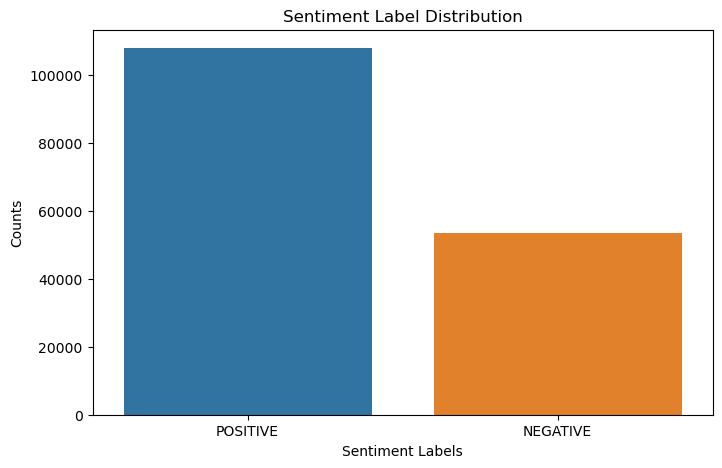

In [24]:

# Data Overview
print("Data Overview:")
print("Number of samples:", len(train))
print("Sample data:")
print(train.head())

# Sentiment Label Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=train['sentiment'])
plt.xlabel('Sentiment Labels')
plt.ylabel('Counts')
plt.title('Sentiment Label Distribution')
plt.show()


We observe that the dataset is imbalanced as Positive sentiment is much more than the negative sentiment

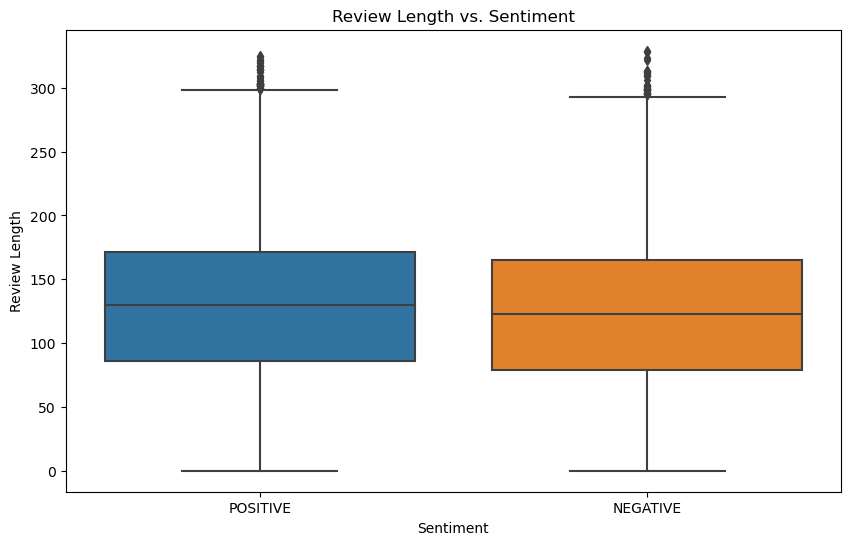

In [25]:
# Review Length vs. Sentiment
train['review_length'] =train['reviewText'].apply(lambda x: len(str(x)))
test['review_length'] =test['reviewText'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=train)
plt.title('Review Length vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

Skewness of Word Count: 0.012783800324990713


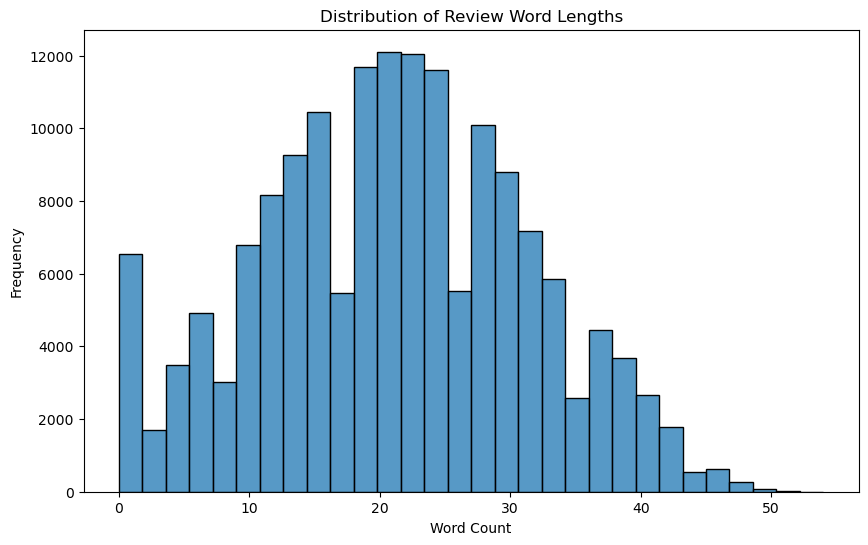

In [26]:
# Review Text Analysis - Word Lengths
from scipy.stats import skew

# Assuming 'train' is your DataFrame
train['word_count'] = train['reviewText'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['reviewText'].apply(lambda x: len(str(x).split()))

# Calculate skewness of 'word_count'
skewness = skew(train['word_count'])
print("Skewness of Word Count:", skewness)

# Plot distribution of review word lengths
plt.figure(figsize=(10, 6))
sns.histplot(train['word_count'], bins=30)
plt.title('Distribution of Review Word Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


We observe little to no skewness in word count 

Skewness of Runtime Minutes (Original): 1.8306204952431062
Skewness after Square Root Transformation: -0.04449679736183594
Skewness after Cube Root Transformation: -0.7115678225735089
Skewness after Log Transformation: -2.3876753045775034


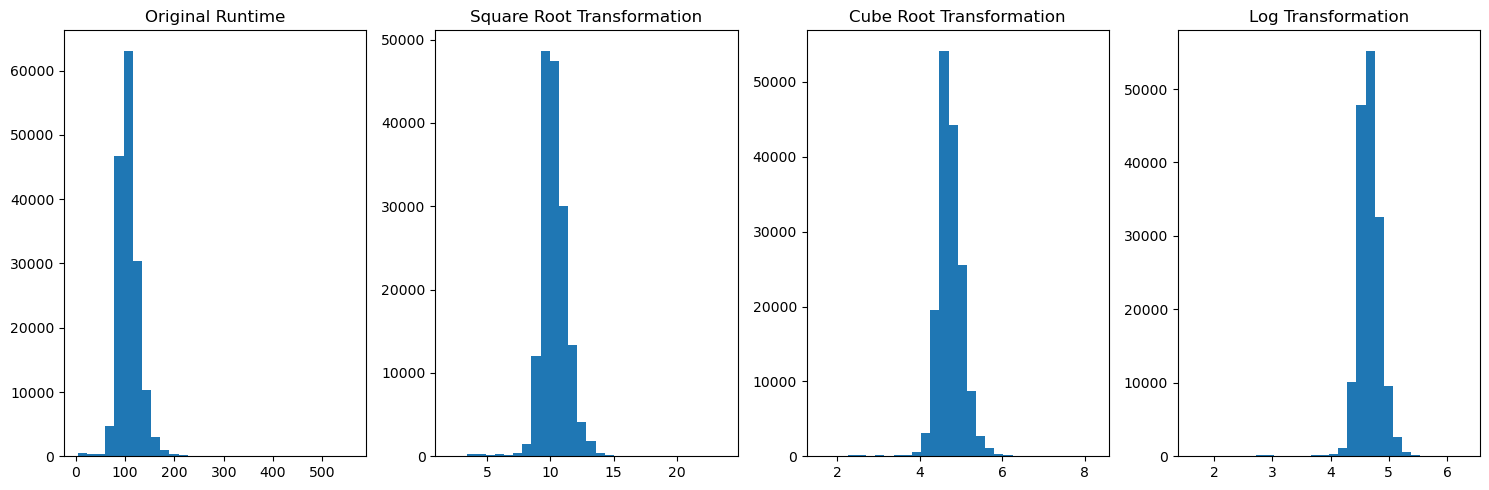

In [27]:

# Assuming 'train' is your DataFrame
train['runtimeMinutes'] = train['runtimeMinutes'].astype(float)  # Convert to numeric if necessary

# Calculate skewness of 'runtimeMinutes'
skewness = skew(train['runtimeMinutes'])
print("Skewness of Runtime Minutes (Original):", skewness)

# Apply square root transformation
train['sqrt_runtime'] = np.sqrt(train['runtimeMinutes'])
skew_sqrt = skew(train['sqrt_runtime'])
print("Skewness after Square Root Transformation:", skew_sqrt)

# Apply cube root transformation
train['cbrt_runtime'] = np.cbrt(train['runtimeMinutes'])
skew_cbrt = skew(train['cbrt_runtime'])
print("Skewness after Cube Root Transformation:", skew_cbrt)

# Apply log transformation (adding a small constant to avoid log(0))
train['log_runtime'] = np.log(train['runtimeMinutes'] + 1)
skew_log = skew(train['log_runtime'])
print("Skewness after Log Transformation:", skew_log)

# Plot original and transformed runtime distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.hist(train['runtimeMinutes'], bins=30)
plt.title('Original Runtime')
plt.subplot(1, 4, 2)
plt.hist(train['sqrt_runtime'], bins=30)
plt.title('Square Root Transformation')
plt.subplot(1, 4, 3)
plt.hist(train['cbrt_runtime'], bins=30)
plt.title('Cube Root Transformation')
plt.subplot(1, 4, 4)
plt.hist(train['log_runtime'], bins=30)
plt.title('Log Transformation')
plt.tight_layout()
plt.show()


In [28]:
# Apply square root transformation to runtime_minutes columns
train['runtimeMinutes_sqrt'] = np.sqrt(train['runtimeMinutes'])
test['runtimeMinutes_sqrt'] = np.sqrt(test['runtimeMinutes'])

We observe that skewness in runtimeMinutes and after transformation we see there observe the least skewness in runtimeMinutes square root so we apply that transformation on train and test datasets. 

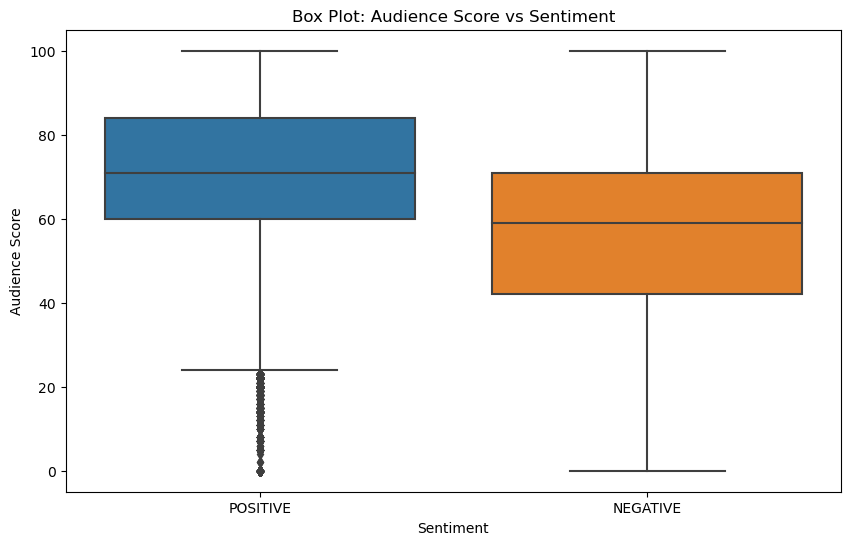

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='audienceScore', data=train)
plt.title('Box Plot: Audience Score vs Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.show()


A box plot is a graphical representation that displays the summary statistics (such as median, quartiles, and potential outliers) of a dataset's distribution.

In this we observe that audience score is high when a sentiment is positive and negative when the audience score is less 

In [30]:

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical features: 'movieid', 'reviewerName', and 'sentiment' 
train['movieid_encoded'] = label_encoder.fit_transform(train['movieid'])
train['reviewerName_encoded'] = label_encoder.fit_transform(train['reviewerName'])
train['sentiment_encoded'] = label_encoder.fit_transform(train['sentiment'])
train['ratingContents_encoded'] = label_encoder.fit_transform(train['ratingContents'])
train['originalLanguage_encoded'] = label_encoder.fit_transform(train['originalLanguage'])
train['director_encoded'] = label_encoder.fit_transform(train['director'])
train['isTopCritic_encoded'] = label_encoder.fit_transform(train['isTopCritic'])
train['boxOffice_encoded'] = label_encoder.fit_transform(train['boxOffice'])


# Compute and print the correlation matrix
correlation_matrix = train.corr()
print(correlation_matrix)


/tmp/ipykernel_20/826272228.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()


                          isTopCritic  audienceScore  runtimeMinutes  \
isTopCritic                  1.000000      -0.027090       -0.031633   
audienceScore               -0.027090       1.000000        0.239379   
runtimeMinutes              -0.031633       0.239379        1.000000   
boxOffice                   -0.053131       0.139928        0.248679   
stream_year                 -0.032634       0.019710       -0.027814   
stream_month                -0.006041       0.004105        0.011758   
stream_day                   0.001662       0.002938        0.044196   
review_length                0.029169       0.027041        0.033946   
word_count                   0.029759       0.018649        0.034415   
sqrt_runtime                -0.032063       0.230380        0.985153   
cbrt_runtime                -0.031709       0.223601        0.972230   
log_runtime                 -0.030198       0.204470        0.931337   
runtimeMinutes_sqrt         -0.032063       0.230380        0.98

 It encodes categorical values into numerical labels, creating new encoded columns. After encoding, it computes the correlation matrix of the DataFrame and prints it. This matrix shows the pairwise correlations between different columns, including the newly encoded ones. Correlation values indicate how strongly pairs of columns are related.

We observe positive correlation between sentiment and  audience score , runtime minutes, genre, stream_year 

/tmp/ipykernel_20/655338179.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()


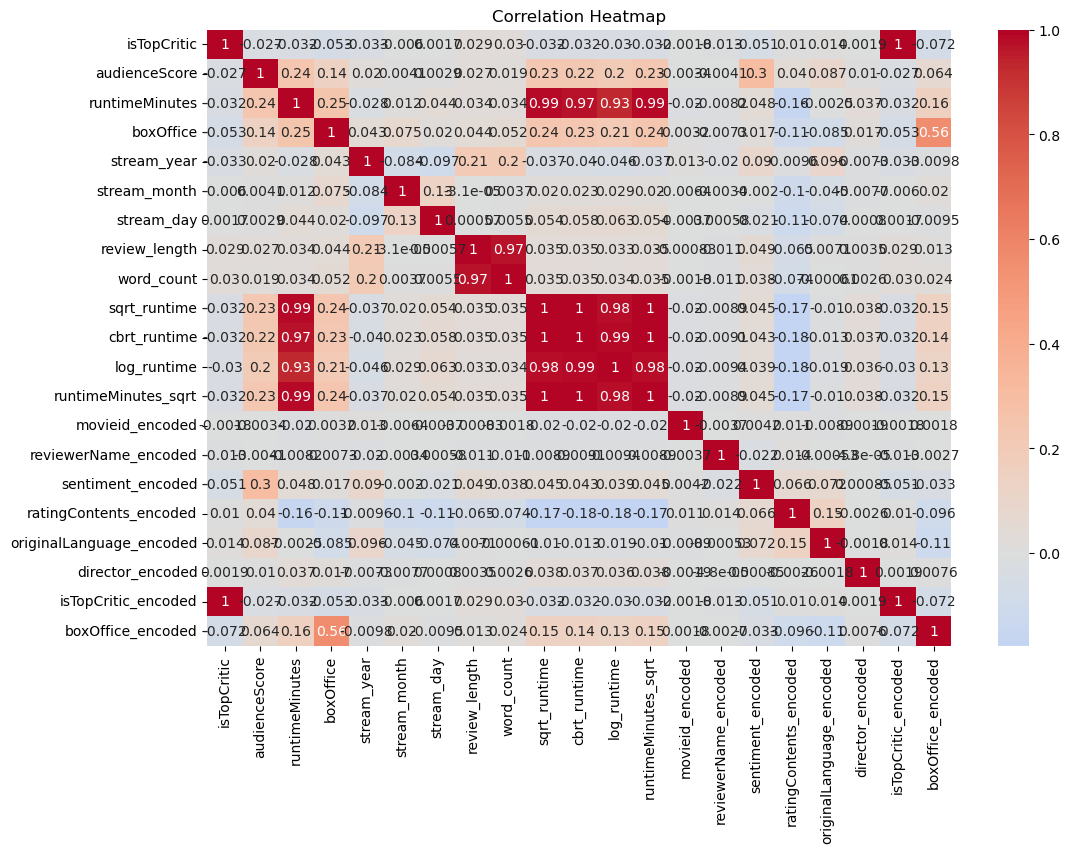

In [31]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Cleaning Review Text

In [32]:
'''
import re 
#remove punctuation
train["reviewText"] = train['reviewText'].str.replace('[^\w\s]','')
test["reviewText"] = test['reviewText'].str.replace('[^\w\s]','')

#lower case
train['reviewText']= train['reviewText'].apply(lambda x: x.lower())
test['reviewText']= test['reviewText'].apply(lambda x: x.lower())

contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not"}

# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
train['reviewText'] = train['reviewText'].apply(lambda x:expand_contractions(x))
test['reviewText'] = test['reviewText'].apply(lambda x:expand_contractions(x))

#removing numbers
train['reviewText'] = train['reviewText'].str.replace('\d+', '')
test['reviewText'] = test['reviewText'].str.replace('\d+', '')

#remove words and digits
train['reviewText'] = train['reviewText'].apply(lambda x: re.sub('W*dw*','',x))
test['reviewText'] = test['reviewText'].apply(lambda x: re.sub('W*dw*','',x)

'''

'\nimport re \n#remove punctuation\ntrain["reviewText"] = train[\'reviewText\'].str.replace(\'[^\\w\\s]\',\'\')\ntest["reviewText"] = test[\'reviewText\'].str.replace(\'[^\\w\\s]\',\'\')\n\n#lower case\ntrain[\'reviewText\']= train[\'reviewText\'].apply(lambda x: x.lower())\ntest[\'reviewText\']= test[\'reviewText\'].apply(lambda x: x.lower())\n\ncontractions_dict = {"ain\'t": "are not","\'s":" is","aren\'t": "are not"}\n\n# Regular expression for finding contractions\ncontractions_re = re.compile(\'(%s)\' % \'|\'.join(contractions_dict.keys()))\n\ndef expand_contractions(text,contractions_dict=contractions_dict):\n    def replace(match):\n        return contractions_dict[match.group(0)]\n    return contractions_re.sub(replace, text)\n\n# Expanding Contractions in the reviews\ntrain[\'reviewText\'] = train[\'reviewText\'].apply(lambda x:expand_contractions(x))\ntest[\'reviewText\'] = test[\'reviewText\'].apply(lambda x:expand_contractions(x))\n\n#removing numbers\ntrain[\'reviewText\']

In [33]:
#the code is removing single characters (single words) and extra whitespace from the 'reviewText' column of both the training and test datasets. 
train['reviewText'] = train['reviewText'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
test['reviewText'] = test['reviewText'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')

/tmp/ipykernel_20/3867152910.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['reviewText'] = train['reviewText'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
/tmp/ipykernel_20/3867152910.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test['reviewText'] = test['reviewText'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')


In [34]:
'''
#defining function for tokenization
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens

#applying function to the column
train['reviewText_token']= train['reviewText'].apply(lambda x: tokenization(x))
test['reviewText_token']= test['reviewText'].apply(lambda x: tokenization(x))
'''

"\n#defining function for tokenization\ndef tokenization(text):\n    tokens = re.split('W+',text)\n    return tokens\n\n#applying function to the column\ntrain['reviewText_token']= train['reviewText'].apply(lambda x: tokenization(x))\ntest['reviewText_token']= test['reviewText'].apply(lambda x: tokenization(x))\n"

In [35]:
#Imputing NaN features in review_length and word_count columns with their mean in test and train dataset
review_length_mean = train['review_length'].mean()
train['review_length'].fillna(review_length_mean, inplace=True)

word_count_mean = train['word_count'].mean()
train['word_count'].fillna(word_count_mean, inplace=True)

review_length_mean = test['review_length'].mean()
test['review_length'].fillna(review_length_mean, inplace=True)

word_count_mean = test['word_count'].mean()
test['word_count'].fillna(word_count_mean, inplace=True)

# Making a Pipeline

TF-IDF (Term Frequency-Inverse Document Frequency) is a text vectorization technique that converts a collection of text documents into numerical vectors. 

StandardScaler is a preprocessing technique used for feature scaling in machine learning. It transforms numerical features by subtracting the mean and dividing by the standard deviation.

OneHotEncoder is used for categorical feature encoding. It converts categorical variables into binary vectors, where each category is represented by a binary column.

In [36]:

X = train.drop(columns=['sentiment'])
y = train['sentiment']

#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocessing steps of different columns
numeric_features = ['audienceScore', 'runtimeMinutes_sqrt']
categorical_features =['originalLanguage', 'genre','director','stream_year','review_length','word_count']
#'word_count ,  'stream_month', 'stream_day'
text_features = 'reviewText'


# Creating a Column Transformer 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', TfidfVectorizer(), text_features),
        ('cate', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create a pipeline that includes the preprocessing and linear SVM model steps
X_new_train = preprocessor.fit_transform(X_train)
X_new_test = preprocessor.transform(X_test)

test1 = preprocessor.transform(test)


lsc = LinearSVC(C = 0.5 , tol = 0.0001)
lsc.fit(X_new_train,y_train)
# Predict on the test data
y_pred_svm = lsc.predict(X_new_test)
accuracy = accuracy_score(y_test, y_pred_svm)

#printing accuracy for the Linear SVC model
accuracy

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8213843103234602

We notice that the model is pretty close to accurate and doesnt suffer from overfitting or underfitting 

In [37]:
y_pred_svm = y_pred_svm = lsc.predict(test1)

In [38]:
y_pred_svm=pd.Series(y_pred_svm)
y_pred_svm.value_counts()

POSITIVE    38859
NEGATIVE    16456
dtype: int64

In [39]:
'''
#specifying param grid for grid search 
param_grid = {
    'C': [ 0.1 , 0.5, 0.01 ],
    'tol': ['0.0001', '0.001' , '0.01'],
}


# Initialize GridSearchCV with the LinearSVC model and parameter grid
grid_search = GridSearchCV(estimator=lsc, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search on your data
grid_search.fit(X_new_train, y_train)  # Replace X_train and y_train with your training data

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
'''

'\n#specifying param grid for grid search \nparam_grid = {\n    \'C\': [ 0.1 , 0.5, 0.01 ],\n    \'tol\': [\'0.0001\', \'0.001\' , \'0.01\'],\n}\n\n\n# Initialize GridSearchCV with the LinearSVC model and parameter grid\ngrid_search = GridSearchCV(estimator=lsc, param_grid=param_grid, cv=5, scoring=\'accuracy\')\n\n# Fit the grid search on your data\ngrid_search.fit(X_new_train, y_train)  # Replace X_train and y_train with your training data\n\n# Print the best parameters and best score\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)\n'

In [40]:
#using logistic regression model 
clf_log = LogisticRegression(solver = 'saga', C= 1.2  )
clf_log.fit(X_new_train,y_train)
y_pred_log= clf_log.predict(X_new_test)
accuracy = accuracy_score(y_test, y_pred_log)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [41]:
#printing accuracy for the logistic regression model
accuracy

0.8243586565869376

In [42]:
y_pred_log_reg = clf_log.predict(test1)

In [43]:
'''
#specifying param grid for grid search
param_grid = {
    'C': [ 1.0, 1.2 , 1.3], 
    'solver': ['saga', 'sag'],  
}
#running grid search for logistic regression 
grid_search = GridSearchCV(estimator=clf_log, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train1,y_train)


#printing the best parameters we get from grid search 
print(grid_search.best_params_)
'''

"\n#specifying param grid for grid search\nparam_grid = {\n    'C': [ 1.0, 1.2 , 1.3], \n    'solver': ['saga', 'sag'],  \n}\n#running grid search for logistic regression \ngrid_search = GridSearchCV(estimator=clf_log, param_grid=param_grid, cv=3, scoring='accuracy')\ngrid_search.fit(X_train1,y_train)\n\n\n#printing the best parameters we get from grid search \nprint(grid_search.best_params_)\n"

Best Parameters: {'C': 1.2, 'solver': saga}
Accuracy : 0.8167678770603545

In [44]:
'''
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


le = LabelEncoder()
y_train_xgb = le.fit_transform(y_train)


clf_lgb = LGBMClassifier(learning_rate = 0.1, n_estimators = 3)
clf_lgb.fit(X_new_train,y_train)

y_pred_lgb = clf_lgb.predict(X_new_test)

#y_pred_lgb = le.inverse_transform(y_pred_lgb)
print(classification_report(y_test, y_pred_lgb))


accuracy = accuracy_score(y_test, y_pred_lgb)
print(accuracy)
'''

'\nfrom sklearn.preprocessing import LabelEncoder\nfrom lightgbm import LGBMClassifier\nfrom sklearn.metrics import classification_report\nfrom sklearn.metrics import accuracy_score\n\n\nle = LabelEncoder()\ny_train_xgb = le.fit_transform(y_train)\n\n\nclf_lgb = LGBMClassifier(learning_rate = 0.1, n_estimators = 3)\nclf_lgb.fit(X_new_train,y_train)\n\ny_pred_lgb = clf_lgb.predict(X_new_test)\n\n#y_pred_lgb = le.inverse_transform(y_pred_lgb)\nprint(classification_report(y_test, y_pred_lgb))\n\n\naccuracy = accuracy_score(y_test, y_pred_lgb)\nprint(accuracy)\n'

In [45]:
'''
#specifying the parameter grid for grid search 
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=clf_lgb, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_new_train, y_train_xgb)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
'''


'\n#specifying the parameter grid for grid search \nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'learning_rate\': [0.1, 0.01, 0.001],\n}\n\n# Create a GridSearchCV instance\ngrid_search = GridSearchCV(estimator=clf_lgb, param_grid=param_grid, cv=3, scoring=\'accuracy\')\n\n# Fit the grid search to the data\ngrid_search.fit(X_new_train, y_train_xgb)\n\n# Print the best parameters and best score\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)\n'

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 300}
Best Score: 0.7925548260451852

In [46]:
#y_pred_lgb = clf_lgb.predict(test1)


In [47]:
submission_1= pd.DataFrame(y_pred_svm,columns= ["sentiment"])
submission_1.to_csv("submission_1.csv", index_label="id")

In [48]:
submission_2= pd.DataFrame(y_pred_log_reg,columns= ["sentiment"])
submission_2.to_csv("submission_2.csv", index_label="id")

In [49]:
'''submission_3= pd.DataFrame(y_pred_lgb,columns= ["sentiment"])
submission_3.to_csv("submission_3.csv", index_label="id")'''

'submission_3= pd.DataFrame(y_pred_lgb,columns= ["sentiment"])\nsubmission_3.to_csv("submission_3.csv", index_label="id")'

In [50]:
submission_1.shape

(55315, 1)

In [51]:
submission_2.shape

(55315, 1)

In [52]:
#submission_3.shape